Summary Statistics for GEx DataFrame:
Total Age Records: 8625, Unknown Age Records: 0
Total Sex Records: 8625, Unknown Sex Records: 0


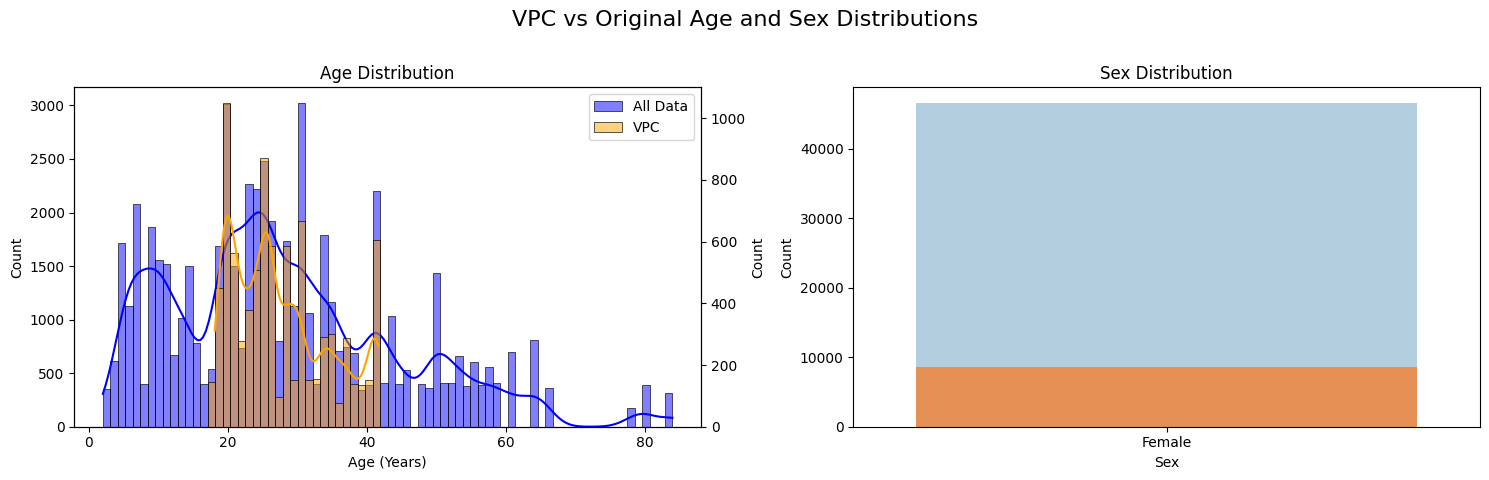

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Load the data from the provided Excel file
file_path = 'Data/Human GEx.xlsx'
data = pd.read_excel(file_path)

# Apply the specified filters
filtered_data = data[data['VPC'] == 1]
filtered_data = filtered_data[filtered_data['Stim'].isin(['Uns', 'IC'])]
filtered_data = filtered_data[filtered_data['Cohort'] == 'Memphis']

filtered_data['Composite_Key'] = filtered_data['Cohort'] + "_" + filtered_data['ID'].astype(str)

# Summary statistics for unknowns in Age and Sex for VPC DataFrame
unknown_age_count_vpc = filtered_data['Age'].isna().sum()
total_age_count_vpc = len(filtered_data['Age'])
unknown_sex_count_vpc = filtered_data['Sex'].isna().sum()
total_sex_count_vpc = len(filtered_data['Sex'])

print(f"Summary Statistics for GEx DataFrame:")
print(f"Total Age Records: {total_age_count_vpc}, Unknown Age Records: {unknown_age_count_vpc}")
print(f"Total Sex Records: {total_sex_count_vpc}, Unknown Sex Records: {unknown_sex_count_vpc}")

# Creating subplots for each status to analyze known Age and Sex distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('VPC vs Original Age and Sex Distributions', fontsize=16)

# Age distribution for known data
# Automatically calculating the number of bins
bins = np.histogram_bin_edges(data['Age'].dropna(), bins='auto')

sns.histplot(data['Age'].dropna(), ax=axes[0], kde=True, bins=bins, color='blue', label='All Data') # All Data
ax_age = axes[0].twinx()
sns.histplot(filtered_data['Age'].dropna(), ax=ax_age, kde=True, bins=bins, color='orange', label='VPC') # VPC-selected

# Restoring the VPC to the legend
lines, labels = axes[0].get_legend_handles_labels()
lines2, labels2 = ax_age.get_legend_handles_labels()
axes[0].legend(lines + lines2, labels + labels2)

axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age (Years)')
axes[0].set_ylabel('Count')

# Sex distribution for known data
# This part remains as is
df_known_sex = data.dropna(subset=['Sex'])
VPC_known_sex = filtered_data.dropna(subset=['Sex'])
sns.countplot(x='Sex', data=df_known_sex, ax=axes[1], palette='Blues', label='All Data')
sns.countplot(x='Sex', data=VPC_known_sex, ax=axes[1], palette='Oranges', label='VPC-selected')
axes[1].set_title('Sex Distribution')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('GEx_vs_original_distribution.svg')
plt.show()

In [19]:
import numpy as np

# Pivot the data for easier calculation of LFC
pivot_data = filtered_data.pivot_table(index=['Composite_Key', 'Gene'], columns='Stim', values='dCt')

# Calculate Log-Fold2 Change (LFC)
# LFC is calculated as log2(IC/Uns), which can be simplified to log2(IC) - log2(Uns)
# This simplifies to IC - Uns due to properties of logarithms
pivot_data['LFC'] = pivot_data['IC'] - pivot_data['Uns']

# Remove rows where either 'Uns' or 'IC' is missing
lfc_data = pivot_data.dropna(subset=['Uns', 'IC'])

# Join back with the original data to get sex information
lfc_with_sex = lfc_data.join(filtered_data.set_index(['Composite_Key', 'Gene'])[['Sex']], how='left')

-1.1347297230114157

In [21]:
from scipy.stats import ttest_ind

# Prepare a dataframe for statistical test results
stat_results = []

# Perform statistical tests for each gene
for gene in lfc_with_sex.index.get_level_values('Gene').unique():
    # Filter data for the current gene
    gene_data = lfc_with_sex.xs(gene, level='Gene')
    
    # Separate data by sex
    males = gene_data[gene_data['Sex'] == 'Male']['LFC']
    females = gene_data[gene_data['Sex'] == 'Female']['LFC']
    
    # Perform t-test
    t_stat, p_value = ttest_ind(males, females, nan_policy='omit', equal_var=False)
    
    # Save the results
    stat_results.append({'Gene': gene, 'T-Statistic': t_stat, 'P-Value': p_value})

# Convert results to a dataframe
stat_results_df = pd.DataFrame(stat_results)

# Display the first few rows of the statistical test results
stat_results_df.head()

# Define the Excel file path for output
output_file_path = 'Gene_Expression_Analysis_Report.xlsx'

# Create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter(output_file_path, engine='xlsxwriter')

# Write each dataframe to a different worksheet
mean_lfc_df = pd.DataFrame({'Mean LFC (Males)': [mean_lfc_males]})
mean_lfc_df.to_excel(writer, sheet_name='Mean LFC Males', index=False)
stat_results_df.to_excel(writer, sheet_name='Statistical Tests', index=False)

# Close the Pandas Excel writer and output the Excel file
writer.save()

output_file_path

C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ModuleNotFoundError: No module named 'xlsxwriter'

In [15]:
# Function to add log2 fold change to the results DataFrame
def add_log2_fold_change(results_df, log_fold_change_male, log_fold_change_female):
    log2_fold_change_values = []
    for index, row in results_df.iterrows():
        gene = row['Gene']
        condition = row['Condition']
        if condition == 'Log2 Fold Change':
            # Calculate average log2 fold change for the gene
            male_log_fc = log_fold_change_male[gene].mean()
            female_log_fc = log_fold_change_female[gene].mean()
            log2_fold_change = male_log_fc - female_log_fc
            log2_fold_change_values.append(log2_fold_change)
        else:
            log2_fold_change_values.append(np.nan)
    results_df['Log2_Fold_Change'] = log2_fold_change_values
    return results_df

# Analyzing Memphis Cohort Alone
memphis_data = reshaped_data[reshaped_data.index.get_level_values('Cohort') == 'Memphis']
p_values_memphis = perform_sex_based_analysis(memphis_data)

# Correcting p-values using FDR for Memphis
p_values_list_memphis = list(p_values_memphis.values())
genes_conditions_memphis = list(p_values_memphis.keys())
corrected_p_values_memphis = multipletests(p_values_list_memphis, method='fdr_bh')[1]

# Creating a DataFrame to store the results for Memphis cohort
results_df_memphis = pd.DataFrame({
    'Gene': [gc[0] for gc in genes_conditions_memphis],
    'Condition': [gc[1] for gc in genes_conditions_memphis],
    'Cohort': 'Memphis',
    'Uncorrected_p_value': p_values_list_memphis,
    'Corrected_p_value': corrected_p_values_memphis,
    'Log2_Fold_Change': [np.nan for _ in genes_conditions_memphis]  # Log2 fold change will be added later
})

# Analyzing Nicaragua Cohort Alone
nicaragua_data = reshaped_data[reshaped_data.index.get_level_values('Cohort') == 'Nicaragua']
p_values_nicaragua = perform_sex_based_analysis(nicaragua_data)

# Correcting p-values using FDR for Nicaragua
p_values_list_nicaragua = list(p_values_nicaragua.values())
genes_conditions_nicaragua = list(p_values_nicaragua.keys())
corrected_p_values_nicaragua = multipletests(p_values_list_nicaragua, method='fdr_bh')[1]

# Creating a DataFrame to store the results for Nicaragua cohort
results_df_nicaragua = pd.DataFrame({
    'Gene': [gc[0] for gc in genes_conditions_nicaragua],
    'Condition': [gc[1] for gc in genes_conditions_nicaragua],
    'Cohort': 'Nicaragua',
    'Uncorrected_p_value': p_values_list_nicaragua,
    'Corrected_p_value': corrected_p_values_nicaragua,
    'Log2_Fold_Change': [np.nan for _ in genes_conditions_nicaragua]  # Log2 fold change will be added later
})

# Combine all results into a single DataFrame
all_results_df = pd.concat([results_df_combined, results_df_memphis, results_df_nicaragua], ignore_index=True)

# Add log2 fold change to the combined DataFrame
log_fold_change_male_combined = np.log2(reshaped_data['IC'] / reshaped_data['Uns'])
log_fold_change_female_combined = np.log2(reshaped_data['IC'] / reshaped_data['Uns'])
all_results_df = add_log2_fold_change(all_results_df, log_fold_change_male_combined, log_fold_change_female_combined)

# Save all results to an Excel file
output_path_all = 'Gene_Expression_Analysis_All_Cohorts.xlsx'
all_results_df.to_excel(output_path_all, index=False)

# Display a subset of the combined results for review
all_results_df.head()


C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)
C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


,Gene,Condition,Cohort,Uncorrected_p_value,Corrected_p_value,Log2_Fold_Change
0,BIK,Uns,Combined,0.855841,NaN,NaN
1,BIK,IC,Combined,NaN,NaN,NaN
2,BIK,Log2 Fold Change,Combined,NaN,NaN,0.0
3,CD80,Uns,Combined,0.190496,NaN,NaN
4,CD80,IC,Combined,0.465126,NaN,NaN
